In [1]:
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import numpy as np
import pandas as pd

import os
from util import values as v
from util.data.dataset_ht import find_group

import napari
from util.data.dataset_nuclei import NucleiDataset
from util.data.dataset_ht import HtDataset, find_group
from util.data import imaging


import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=UserWarning)

matplotlib.rc("figure", figsize=(15, 5))
plt.style.use('default')

Create a DataFrame with the number of nuclei and membranes per group

Intensity decay

In [16]:
from scipy.optimize import curve_fit
import numpy as np
import matplotlib.pyplot as plt

def compute_z_profile(image_stack, mask_stack):
    # The third dimension is the number of z-slices
    z_slices = image_stack.shape[2]
    
    # Binary mask of the nuclei
    mask_stack = mask_stack > 0
    
    fg_means = []
    bg_means = []
    
    for z in range(z_slices):
        # Extract the 2D slice at depth z
        slice_2d = image_stack[..., z]
        mask_2d  = mask_stack[..., z]
        
        try:
            # Foreground (nuclei) intensities
            fg_pixels = slice_2d[mask_2d]
            
            # Background intensities
            bg_pixels = slice_2d[~mask_2d]
            
            # Compute mean values (or any statistic you prefer)
            fg_means.append(np.mean(fg_pixels))
            bg_means.append(np.mean(bg_pixels))
        except Exception as e:
            print(f"Error at z={z}: {e}")
            fg_means.append(0)
            bg_means.append(0)
    
    return np.array(fg_means), np.array(bg_means)

def compute_z_profile_no_mask(image_stack):
    """
    Compute the mean intensity profile along the z-axis of an image stack. The foreground mask will be assessed by a simple min between max umbralization
    """
    z_slices = image_stack.shape[2]
    fg_means = []
    bg_means = []
    
    for z in range(z_slices):
        slice_2d = image_stack[..., z]
        umbral = np.min([np.max(slice_2d), np.mean(slice_2d) + 3*np.std(slice_2d)])
        mask_2d = slice_2d > umbral
        
        try:
            fg_pixels = slice_2d[mask_2d]
            bg_pixels = slice_2d[~mask_2d]
            
            fg_means.append(np.mean(fg_pixels))
            bg_means.append(np.mean(bg_pixels))
        except Exception as e:
            print(f"Error at z={z}: {e}")
            fg_means.append(0)
            bg_means.append(0)
    
    return np.array(fg_means), np.array(bg_means)

def fit_exponential_decay(z_indices, intensities):
    """
    Fit an exponential decay to (z, intensities) data.
    p0 is an initial guess for (a, b, c).
    Returns: popt, pcov from curve_fit
    """
    # Filter out NaNs (if any remain)
    valid_mask = np.isfinite(intensities)
    z_valid = z_indices[valid_mask]
    intens_valid = intensities[valid_mask]

    if len(intens_valid) < 3:
        raise ValueError("Not enough valid data points to fit exponential decay.")

    # Initial guess
    a_init = np.max(intens_valid)
    # If intens_valid[-1] < a_init, estimate b_init from difference
    b_init = 0.1
    if intens_valid[-1] < a_init:
        # Avoid log(0) if intens_valid[-1] is zero
        ratio = intens_valid[-1]/a_init if intens_valid[-1] != 0 else 1e-9
        depth_range = z_valid[-1] - z_valid[0] if (z_valid[-1] - z_valid[0]) != 0 else 1e-9
        b_init = -np.log(ratio) / depth_range

    c_init = np.min(intens_valid)
    p0 = (a_init, max(b_init, 1e-5), c_init)

    popt, pcov = curve_fit(exp_decay, z_valid, intens_valid, p0=p0, maxfev=5000)
    return popt

In [19]:
s = '0521_E1'
ds = HtDataset(data_path=v.data_path)

raw_path, _ = ds.read_specimen(s, 'Nuclei', 'RawImages', False, verbose=1)
seg_path, _ = ds.read_specimen(s, 'Nuclei', 'Segmentation', False, verbose=1)
lines_path, _ = ds.read_line(s, verbose=1)

raw_img = imaging.read_image(raw_path)
seg_img = imaging.read_image(seg_path)
lines_img = imaging.read_image(lines_path)

print(raw_img.shape, seg_img.shape, lines_img.shape)


	Found: 20190521_E1_DAPI_decon_0.5.nii.gz

	Found: 20190521_E1_mask_all.nii.gz
	Found: line_20190521_E1.nii.gz
(1024, 1024, 481) (1024, 1024, 481) (1024, 1024, 481)


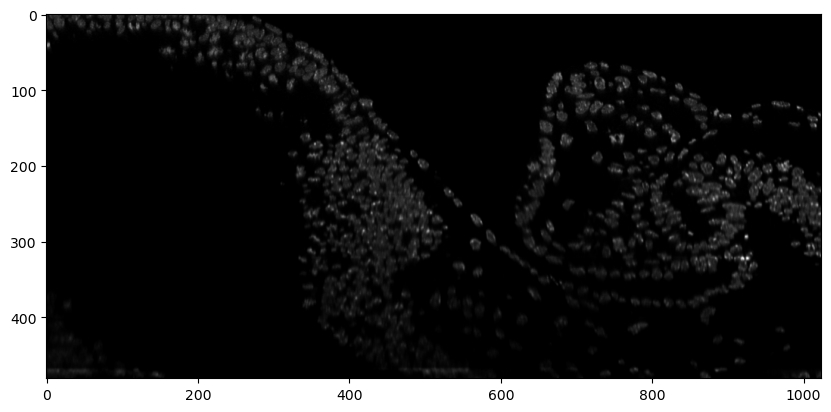

In [53]:
aux = imaging.read_image(raw_path, axes='ZYX')

plt.figure(figsize=(10, 10))
plt.imshow(aux[..., 509], cmap='gray')
plt.show()

In [4]:
from filtering import cardiac_region as cr

margins = cr.get_margins(lines_path, raw_path, tissue='myocardium', verbose=1)
# margins = (
#     np.array([450, 350, 250]),
#     np.array([550, 450, 400])
# )

# margins = (
#     np.array([450, 550, 250]),
#     np.array([550, 650, 400])
# )

raw_img = cr.crop_img(raw_img, margins)
seg_img = cr.crop_img(seg_img, margins)

imaging.save_nii(raw_img, 'raw_crop_myo.nii.gz', verbose=1)
imaging.save_nii(seg_img, 'seg_crop_myo.nii.gz', verbose=1)

Margin around line: 10
Line metadata: {'x_size': 1024, 'y_size': 1024, 'z_size': 481, 'x_res': 0.757206, 'y_res': 0.757206, 'z_res': 1.038765}
Line shape: (1024, 1024, 481)

Saving prediction: raw_crop_myo.nii.gz

Saving prediction: seg_crop_myo.nii.gz


In [ ]:
# aux_path, _ = ds.read_specimen(s, 'Nuclei', 'Segmentation', True, verbose=1)
# 
# aux_img = imaging.read_image(seg_path)
# aux_img = cr.crop_img(aux_img, margins)
# 
# imaging.save_nii(aux_img, 'seg_crop_just_myo.nii.gz', verbose=1)
# viewer.add_image(aux_img, name='Myo', colormap='red')


	Found: 20190521_E1_mask_all_myocardium.nii.gz


In [5]:
import napari

viewer = napari.Viewer()
viewer.add_image(raw_img, name='Raw', colormap='gray')
viewer.add_image(seg_img, name='Segmentation', colormap='red')

<Image layer 'Segmentation' at 0x779ed848be20>

In [3]:
def log_decay(z, a, b, c):
    """
    A simple logarithmic decay function:
    f(z) = a - b * ln(z + c)

    Make sure z + c > 0 for all z in your domain.
    """
    return a - b * np.log(z + c)

def fit_logarithmic_decay(z_indices, intensities):
    """
    Fit a logarithmic decay to (z, intensities) data, assuming a model:
    f(z) = a - b * ln(z + c)

    Returns:
      popt: (a, b, c) - fitted parameters
      pcov: Covariance matrix of the fit
    """
    # 1. Filter out any invalid (NaN/inf) values
    valid_mask = np.isfinite(intensities)
    z_valid = z_indices[valid_mask]
    intens_valid = intensities[valid_mask]

    if len(intens_valid) < 3:
        raise ValueError("Not enough valid data points to fit logarithmic decay.")

    # 2. Initial guesses for (a, b, c)
    #    We'll guess 'a' ~ max of intensities,
    #    'b' is a positive scaling factor,
    #    'c' is a small shift to keep the argument of log() > 0.
    a_init = np.max(intens_valid)
    b_init = (a_init - np.min(intens_valid)) #/ 2.0  # rough guess
    # Ensure all z_valid + c_init > 0
    # If z_valid starts at 0, we can set c_init to something small like 1
    c_init = 1.0
    if np.min(z_valid) > 0:
        # we can set c_init so that min(z_valid + c_init) is > 0
        # e.g., c_init = -min(z_valid)/2 if min(z_valid) is negative (but typically not)
        pass

    p0 = (a_init, b_init, c_init)

    # 3. Fit with curve_fit
    popt, pcov = curve_fit(
        log_decay, 
        z_valid, 
        intens_valid, 
        p0=p0,
        maxfev=20000
    )

    return popt

In [4]:
def gompertz(x, a, b, c):
    return a * np.exp(-b * np.exp(-c * x))

def fit_gompertz(xdata, ydata):
    mask = np.isfinite(xdata) & np.isfinite(ydata)
    x_valid = xdata[mask]
    y_valid = ydata[mask]

    # Simple guesses
    a_init = np.max(y_valid)
    b_init = 1.0
    c_init = 0.01

    popt, pcov = curve_fit(gompertz, x_valid, y_valid, p0=(a_init, b_init, c_init), maxfev=100000)
    return popt

In [5]:
def bi_exponential(x, a1, b1, a2, b2, c):
    """
    Bi-exponential decay:
    f(x) = a1 * exp(-b1*x) + a2 * exp(-b2*x) + c
    """
    return a1 * np.exp(-b1 * x) + a2 * np.exp(-b2 * x) + c

def fit_bi_exponential(xdata, ydata, max_x=None, maxfev=100000):
    """
    Fit a bi-exponential decay to (xdata, ydata).
    Optionally exclude data beyond `max_x` if you want to ignore an end spike or outliers.
    """
    # 1) If you want to exclude tail points, do so here:
    if max_x is not None:
        mask = (xdata <= max_x)
    else:
        mask = np.ones_like(xdata, dtype=bool)

    # Also ensure we skip NaNs or Infs
    mask &= np.isfinite(xdata) & np.isfinite(ydata)

    x_valid = xdata[mask]
    y_valid = ydata[mask]
    
    if len(x_valid) < 5:
        raise ValueError("Not enough valid data points for a bi-exponential fit.")
    
    # 2) Provide initial guesses:
    y_start = y_valid[0]
    y_end   = y_valid[-1]
    # Total drop from start to end
    total_diff = max(y_start - y_end, 1e-6)

    # Heuristic guesses:
    a1_init = 0.3 * total_diff
    a2_init = 0.7 * total_diff
    b1_init = 0.01  # faster or slower rate guesses
    b2_init = 0.1
    c_init  = y_end  # baseline near the end

    p0 = [a1_init, b1_init, a2_init, b2_init, c_init]

    # 3) Fit with curve_fit
    popt, pcov = curve_fit(
        bi_exponential, 
        x_valid, 
        y_valid, 
        p0=p0,
        maxfev=maxfev
    )
    return popt

In [19]:
def logistic_inverted(x, L, U, k, x0):
    """
    Inverted logistic that goes from ~U down to ~L:
    f(x) = L + (U - L) / [1 + exp(k * (x - x0))]
    """
    return L + (U - L) / (1.0 + np.exp(k * (x - x0)))

def fit_inverted_logistic(xdata, ydata, p0=None, maxfev=50000):
    """
    Fit the inverted logistic model to (xdata, ydata).
    p0 = (L, U, k, x0) if you want to supply guesses manually.
    """
    mask = np.isfinite(xdata) & np.isfinite(ydata)
    x_valid, y_valid = xdata[mask], ydata[mask]

    if len(x_valid) < 5:
        raise ValueError("Not enough data points to fit a logistic.")

    # If no initial guess is provided, estimate from data
    if p0 is None:
        L_init = np.min(y_valid)
        U_init = np.max(y_valid)
        # x0 ~ the midpoint of x range (rough guess)
        x0_init = 0.5 * (x_valid.min() + x_valid.max())  
        # slope guess k from the 'steepest' region; let's just pick something small
        k_init  = 0.01
        p0 = [L_init, U_init, k_init, x0_init]

    popt, pcov = curve_fit(
        logistic_inverted, 
        x_valid, 
        y_valid, 
        p0=p0, 
        maxfev=maxfev
    )
    return popt

def correction_factor(z, popt, z_ref=0.0):
    """
    Compute CF(z) = f(z_ref)/f(z),
    where f is the inverted logistic model.
    popt = [L, U, k, x0] from the curve fit.
    """
    L, U, k, x0 = popt
    f_z = logistic_inverted(z, L, U, k, x0)
    f_ref = logistic_inverted(z_ref, L, U, k, x0)  # reference slice intensity
    # Avoid divide-by-zero if any f_z is ~ 0
    return np.where(f_z != 0, f_ref / f_z, 1.0)

In [103]:
s = '0403_E2'
ds = HtDataset(data_path=v.data_path)

raw_path, _ = ds.read_specimen(s, 'Nuclei', 'RawImages', False, verbose=1)
seg_path, _ = ds.read_specimen(s, 'Nuclei', 'Segmentation', False, verbose=1)
# lines_path, _ = ds.read_line(s, verbose=1)

raw_img = imaging.read_image(raw_path)
seg_img = imaging.read_image(seg_path)
# lines_img = imaging.read_image(lines_path)

# print(raw_img.shape, seg_img.shape, lines_img.shape)


	Found: 20190403_E2_DAPI_decon_0.5.nii.gz

	Found: 20190403_E2_mask_all.nii.gz


In [17]:
raw_path = '/run/user/1003/gvfs/smb-share:server=tierra.cnic.es,share=temporal/MorenaNacho/RawImages/DAPI_3micras_0.5.nii.gz'
# seg_path, _ = ds.read_specimen('0521_E1', 'Nuclei', 'Segmentation', False, verbose=1)

raw_img = imaging.read_image(raw_path).astype(np.int16)
# seg_img = imaging.read_image(seg_path)

In [125]:
# Compress imgage to .nii.gz
# imaging.save_nii(raw_img, 'calibrated.nii.gz', verbose=1)
raw_img = imaging.read_image('calibrated.nii.gz').astype(np.int8)

Fitted parameters: [ 45.4880813  179.60350341   0.19051223  27.34499427]

Saving prediction: decon_0.5_16_calibrated.nii.gz


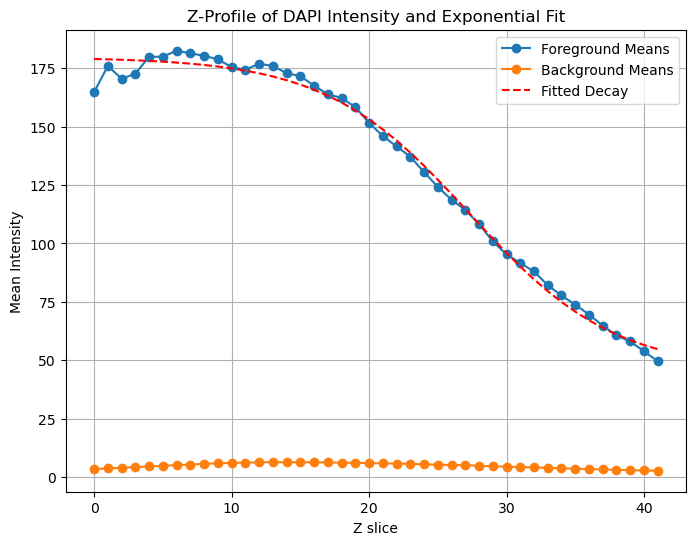

In [22]:

# Example usage
# Assuming 'image_stack' is your 3D DAPI data and 'mask_stack' is your nuclear segmentation
z_slices = raw_img.shape[2]
z_indices = np.arange(z_slices)
# fg_means, bg_means = compute_z_profile(raw_img, seg_img)
fg_means, bg_means = compute_z_profile_no_mask(raw_img)

# for i, val in enumerate(fg_means):
#     if np.isnan(val):
#         fg_means[i] = 0

def exp_decay(z, a, b, c):
    """
    Simple exponential decay model:
    f(z) = a * exp(-b * z) + c
    """
    return a * np.exp(-b * z) + c

# Optionally fit a decay function to foreground means
# popt = fit_exponential_decay(z_indices, fg_means)
# popt = fit_logarithmic_decay(z_indices, fg_means)
# popt = fit_gompertz(z_indices, fg_means)
# popt = fit_bi_exponential(z_indices, fg_means)
popt = fit_inverted_logistic(z_indices, fg_means)
# popt = [a, b, c] if using the exp_decay definition
# a, b, c = popt
# a1, b1, a2, b2, c = popt
L, U, k, x0 = popt
print("Fitted parameters:", popt)

# Create a correction factor for each z
# Correction factor = 1 / (f(z)/f(0)) or some reference
# For a decaying function: f(z) = a * exp(-b * z) + c
# f0 = a + c  
# approximate value at z=0
# f0 = a1 + a2 + c
correction_factors = []

for z in z_indices:
    cf_i = correction_factor(z, popt, z_ref=0.0)
    correction_factors.append(cf_i)

# Apply correction to entire stack
corrected_stack = np.zeros_like(raw_img, dtype=np.float16)
for z in range(z_slices):
    corrected_stack[..., z] = raw_img[..., z] * correction_factors[z]

imaging.save_nii(corrected_stack.astype(np.uint32), 'decon_0.5_16_calibrated.nii.gz', verbose=1)

# Plot the mean intensities along z
plt.figure(figsize=(8,6))

# Plot foreground and background means
plt.plot(z_indices, fg_means, '-o', label='Foreground Means')
plt.plot(z_indices, bg_means, '-o', label='Background Means')

# Generate a smooth curve to plot the fitted function
z_fit = np.linspace(z_indices.min(), z_indices.max(), len(z_indices))  
# y_fit = a * np.exp(-b * z_fit) + c
# y_fit = log_decay(z_fit, a, b, c)
# y_fit = gompertz(z_fit, a, b, c)
# y_fit = bi_exponential(z_fit, a1, b1, a2, b2, c)
y_fit = logistic_inverted(z_fit, L, U, k, x0)

# Plot the fitted decay curve in red, dashed
plt.plot(z_fit, y_fit, 'r--', label='Fitted Decay')

plt.xlabel('Z slice')
plt.ylabel('Mean Intensity')
plt.title('Z-Profile of DAPI Intensity and Exponential Fit')
plt.legend()
plt.grid(True)
plt.show()

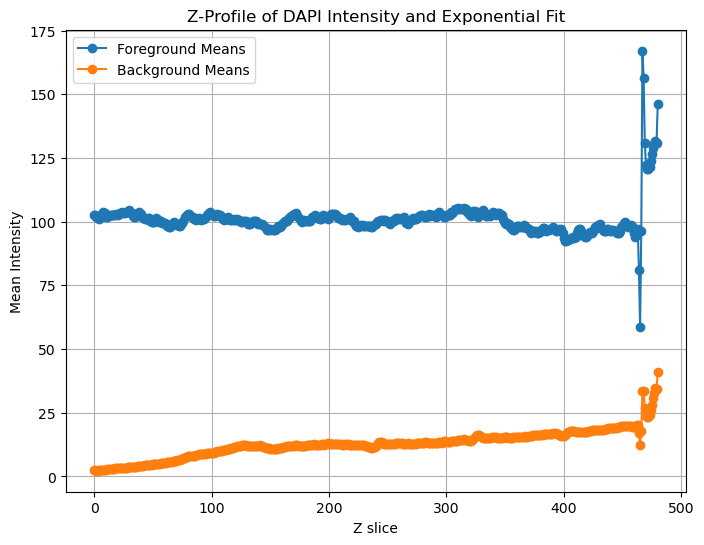

In [130]:
z_slices = corrected_stack.shape[2]
z_indices = np.arange(z_slices)
fg_means, bg_means = compute_z_profile(corrected_stack, seg_img)

plt.figure(figsize=(8,6))

# Plot foreground and background means
plt.plot(z_indices, fg_means, '-o', label='Foreground Means')
plt.plot(z_indices, bg_means, '-o', label='Background Means')
plt.xlabel('Z slice')
plt.ylabel('Mean Intensity')
plt.title('Z-Profile of DAPI Intensity and Exponential Fit')
plt.legend()
plt.grid(True)
plt.show()

In [14]:
test = imaging.read_image('/run/user/1003/gvfs/smb-share:server=tierra.cnic.es,share=temporal/Morena Nacho/RawImages/DAPI_3micras.tif')
# test = read_lif('/run/user/1003/gvfs/smb-share:server=tierra.cnic.es,share=temporal/Morena Nacho/RawImages/prueba TUNEL 488 cas3 633 E6.5 en glicerol.lif')
print(test.shape)

(2048, 2048, 42)


In [26]:
print(f'Fitted parameters: a={a:.2f}, b={b:.2f}, c={c:.2f}')
print(f'{a} * e^(-{b}*z) + {c}')

Fitted parameters: a=129862.89, b=0.00, c=-129830.84
129862.88727357495 * e^(-2.707778966869484e-07*z) + -129830.84092152223


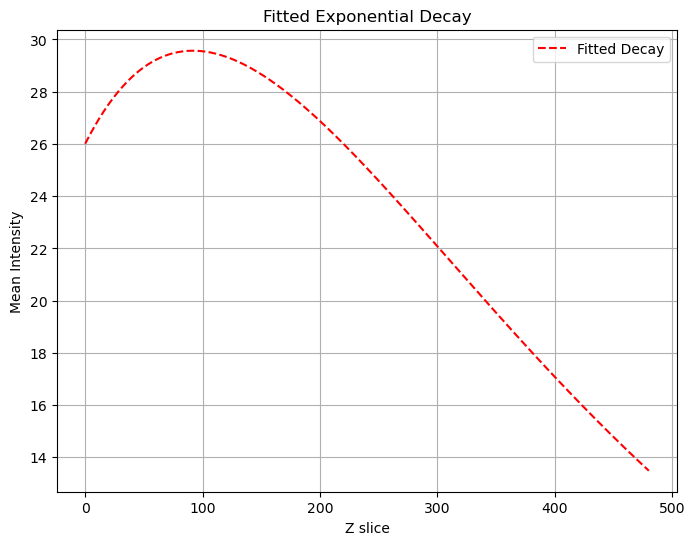

In [95]:
z_fit = np.linspace(z_indices.min(), z_indices.max(), len(z_indices))  
# y_fit = a * np.exp(-b * z_fit) + c
# y_fit = log_decay(z_fit, a, b, 10)
# y_fit = gompertz(z_fit, a, b, c)
y_fit = bi_exponential(z_fit, a1, b1, a2, b2, c)

plt.figure(figsize=(8,6))
plt.plot(z_fit, y_fit, 'r--', label='Fitted Decay')
plt.xlabel('Z slice')
plt.ylabel('Mean Intensity')
plt.title('Fitted Exponential Decay')
plt.grid(True)  
plt.legend()
plt.show()

In [67]:
import napari

viewer = napari.Viewer()
viewer.add_image(raw_img, name='Raw Image', colormap='gray')

<Image layer 'Raw Image' at 0x77d7021e9e70>

Check celldiv classes

In [15]:
all_feat = []

for i, s in enumerate(v.specimens_to_analyze):
    gr = find_group(s)
    print(s, gr)
        
    try:
        ds = HtDataset(data_path=v.data_path)
        features = ds.get_features(s, 'Nuclei', 'myocardium', verbose=1, filtered=True)
        all_feat.extend(features['cell_division'].dropna().values)
    except Exception as e:
        print(e)
        continue
        
print(np.unique(all_feat))

# Count number of instances per class
counts = {k: 0 for k in np.unique(all_feat)}
for k in all_feat:
    counts[k] += 1
    
print(counts)

0806_E5 Gr1
	Found: 20190806_E5_cell_properties_radiomics_Nuclei_myocardium.csv
0504_E1 Gr1
	Found: 20190504_E1_cell_properties_radiomics_Nuclei_myocardium.csv
0521_E4 Gr1
	Found: 20190521_E4_cell_properties_radiomics_Nuclei_myocardium.csv
0516_E2 Gr2
	Found: 20190516_E2_cell_properties_radiomics_Nuclei_myocardium.csv
0503_E1 Gr2
	Found: 20190503_E1_cell_properties_radiomics_Nuclei_myocardium.csv
0209_E1 Gr2
	Found: 20190209_E1_cell_properties_radiomics_Nuclei_myocardium.csv
0520_E2 Gr2
	Found: 20190520_E2_cell_properties_radiomics_Nuclei_myocardium.csv
0209_E2 Gr3
	Found: 20190209_E2_cell_properties_radiomics_Nuclei_myocardium.csv
0503_E2 Gr3
	Found: 20190503_E2_cell_properties_radiomics_Nuclei_myocardium.csv
0516_E3 Gr3
	Found: 20190516_E3_cell_properties_radiomics_Nuclei_myocardium.csv
0521_E1 Gr4
	Found: 20190521_E1_cell_properties_radiomics_Nuclei_myocardium.csv
0523_E1 Gr4
	Found: 20190523_E1_cell_properties_radiomics_Nuclei_myocardium.csv
0806_E3 Gr4
	Found: 20190806_E3_cell_pro

In [75]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from util import values as v
from util.data.dataset_ht import HtDataset, find_group

# Dictionaries to store per-group and per-embryo data
nuclei_data = {}
membranes_data = {}

# Also create a list to store embryo-level data
embryo_records = []

for s in v.specimens_list:
    gr = find_group(s)
    print(s, gr)
    if gr == 'Gr10':
        continue
        
    if gr not in ['Gr8', 'Gr9'] and s not in v.specimens_to_analyze:
        continue
        
    try:
        ds = HtDataset(data_path=v.data_path) #  + 'auxiliary/'
        
        try:
            features_mem = ds.get_features(s, 'Membrane', 'myocardium', verbose=1, filtered=True)
            features_nu = ds.get_features(s, 'Nuclei', 'myocardium', verbose=1, filtered=True)
        except Exception as e:
            features_mem = ds.get_features(s, 'Membrane', 'myocardium', verbose=1, filtered=False)
            features_nu = ds.get_features(s, 'Nuclei', 'myocardium', verbose=1, filtered=False)
        
        membranes_count = len(features_mem)
        nuclei_count = len(features_nu)
        
        # Append embryo-level data record
        embryo_records.append({
            'Specimen': s,
            'Group': gr,
            'Nuclei': nuclei_count,
            'Membranes': membranes_count
        })
        
        # Store data into group-level lists
        if gr not in nuclei_data:
            nuclei_data[gr] = []
            membranes_data[gr] = []
        
        nuclei_data[gr].append(nuclei_count)
        membranes_data[gr].append(membranes_count)

    except Exception as e:
        print(e)
        continue

# Create a DataFrame with embryo-level data
df_embryos = pd.DataFrame(embryo_records)

# Compute mean and std per group
summary = {
    'Group': [],
    'NoSpecimens': [],
    'Nuclei_mean': [],
    'Nuclei_std': [],
    'Membranes_mean': [],
    'Membranes_std': []
}

for gr in sorted(nuclei_data.keys()):
    nuc_vals = nuclei_data[gr]
    mem_vals = membranes_data[gr]

    summary['Group'].append(gr)
    summary['NoSpecimens'].append(len(nuc_vals))
    summary['Nuclei_mean'].append(np.mean(nuc_vals))
    summary['Nuclei_std'].append(np.std(nuc_vals, ddof=1))
    summary['Membranes_mean'].append(np.mean(mem_vals))
    summary['Membranes_std'].append(np.std(mem_vals, ddof=1))

df_summary = pd.DataFrame(summary)

# Save summary DataFrame
df_summary.to_csv(v.data_path + 'FeaturesGeneral/group_cells.csv', index=False)

# Save embryo-level DataFrame
df_embryos.to_csv(v.data_path + 'FeaturesGeneral/embryo_cells.csv', index=False)

print("Summary DataFrame (group-level):")
print(df_summary.head(9))

print("Embryo-level DataFrame:")
print(df_embryos.head(9))

0806_E5 Gr1
	Found: 20190806_E5_cell_properties_radiomics_Membrane_myocardium.csv
	Found: 20190806_E5_cell_properties_radiomics_Nuclei_myocardium.csv
0504_E1 Gr1
	Found: 20190504_E1_cell_properties_radiomics_Membrane_myocardium.csv
	Found: 20190504_E1_cell_properties_radiomics_Nuclei_myocardium.csv
0208_E2 Gr1
0521_E4 Gr1
	Found: 20190521_E4_cell_properties_radiomics_Membrane_myocardium.csv
	Found: 20190521_E4_cell_properties_radiomics_Nuclei_myocardium.csv
0521_E2 Gr1
0516_E2 Gr2
	Found: 20190516_E2_cell_properties_radiomics_Membrane_myocardium.csv
	Found: 20190516_E2_cell_properties_radiomics_Nuclei_myocardium.csv
0503_E1 Gr2
	Found: 20190503_E1_cell_properties_radiomics_Membrane_myocardium.csv
	Found: 20190503_E1_cell_properties_radiomics_Nuclei_myocardium.csv
0209_E1 Gr2
	Found: 20190209_E1_cell_properties_radiomics_Membrane_myocardium.csv
	Found: 20190209_E1_cell_properties_radiomics_Nuclei_myocardium.csv
0520_E2 Gr2
	Found: 20190520_E2_cell_properties_radiomics_Membrane_myocardiu

/home/imarcoss/mambaforge/envs/py310ml/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/imarcoss/mambaforge/envs/py310ml/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [76]:
df_summary = pd.read_csv(v.data_path + 'FeaturesGeneral/group_cells.csv')
df_embryos = pd.read_csv(v.data_path + 'FeaturesGeneral/embryo_cells.csv')

Time series analysis

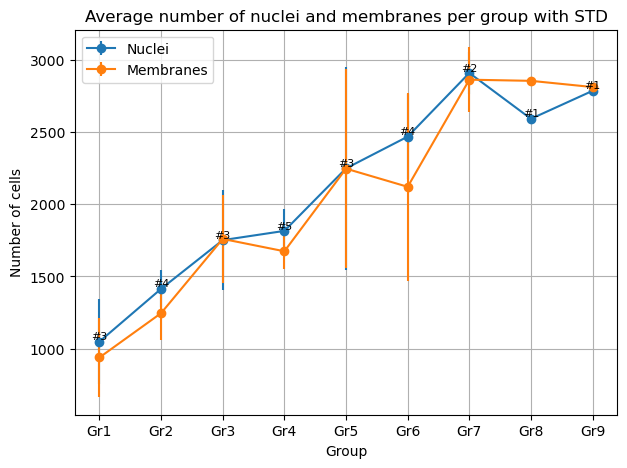

In [77]:
plt.figure(figsize=(7, 5))
plt.errorbar(
    df_summary['Group'], df_summary['Nuclei_mean'], 
    yerr=df_summary['Nuclei_std'], fmt='-o', label='Nuclei'
)
plt.errorbar(
    df_summary['Group'], df_summary['Membranes_mean'], 
    yerr=df_summary['Membranes_std'], fmt='-o', label='Membranes'
)

for i, row in df_summary.iterrows():
    plt.text(
        row['Group'], row['Nuclei_mean'], 
        f"#{row['NoSpecimens']}", ha='center', 
        va='bottom', fontsize=8
    )

plt.xlabel('Group')
plt.ylabel('Number of cells')
plt.title('Average number of nuclei and membranes per group with STD')
plt.grid(True)
plt.legend()
plt.show()


Ratio segmented nuclei/cell analysis

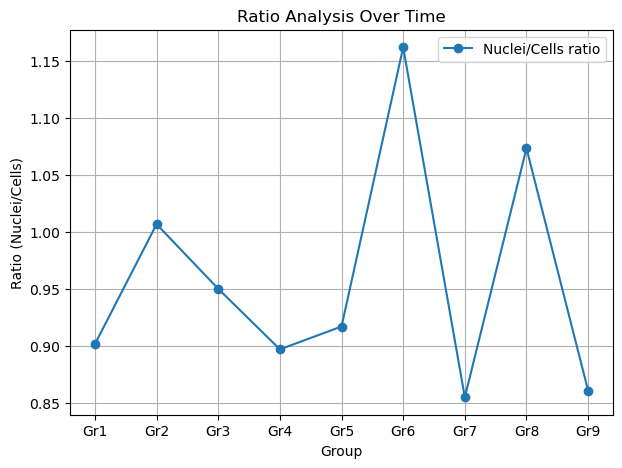

In [33]:
df_summary['Ratio'] = df_summary['Nuclei_mean'] / df_summary['Membranes_mean']

plt.figure(figsize=(7,5))
plt.plot(df_summary['Group'], df_summary['Ratio'], '-o', label='Nuclei/Cells ratio')
plt.xlabel('Group')
plt.ylabel('Ratio (Nuclei/Cells)')
plt.title('Ratio Analysis Over Time')
plt.grid(True)
plt.legend()
plt.show()


Lienar modeling

- Model: Nuclei = a*Membranes + b



Linear model: Nuclei = a*Membranes + b
a = 0.8809712561918774
b = 302.48449084193


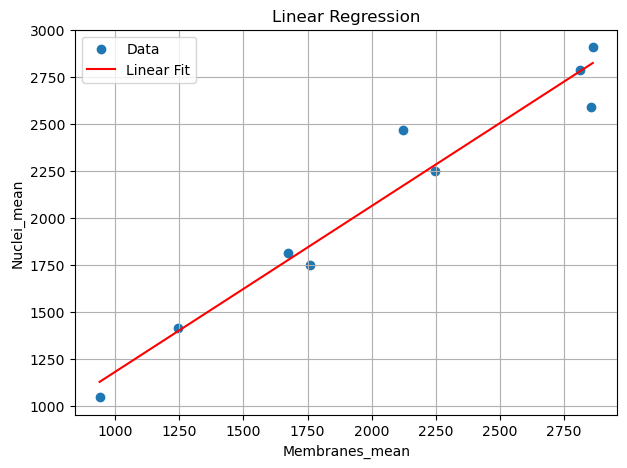

In [78]:
from sklearn.linear_model import LinearRegression

X = df_summary[['Membranes_mean']].values
y = df_summary['Nuclei_mean'].values

lin_reg = LinearRegression()
lin_reg.fit(X, y)

print("Linear model: Nuclei = a*Membranes + b")
print("a =", lin_reg.coef_[0])
print("b =", lin_reg.intercept_)

# Plot regression line
plt.figure(figsize=(7,5))
plt.scatter(df_summary['Membranes_mean'], df_summary['Nuclei_mean'], label='Data')
x_line = np.linspace(df_summary['Membranes_mean'].min(), df_summary['Membranes_mean'].max(), 100)
y_line = lin_reg.predict(x_line.reshape(-1,1))
plt.plot(x_line, y_line, 'r-', label='Linear Fit')
plt.xlabel('Membranes_mean')
plt.ylabel('Nuclei_mean')
plt.title('Linear Regression')
plt.grid(True)
plt.legend()
plt.show()


- Model: Nuclei = a*Group + b

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.913
Model:                            OLS   Adj. R-squared:                  0.901
Method:                 Least Squares   F-statistic:                     73.80
Date:                Mon, 06 Jan 2025   Prob (F-statistic):           5.77e-05
Time:                        19:32:48   Log-Likelihood:                -59.420
No. Observations:                   9   AIC:                             122.8
Df Residuals:                       7   BIC:                             123.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        994.0542    146.856      6.769      0.0

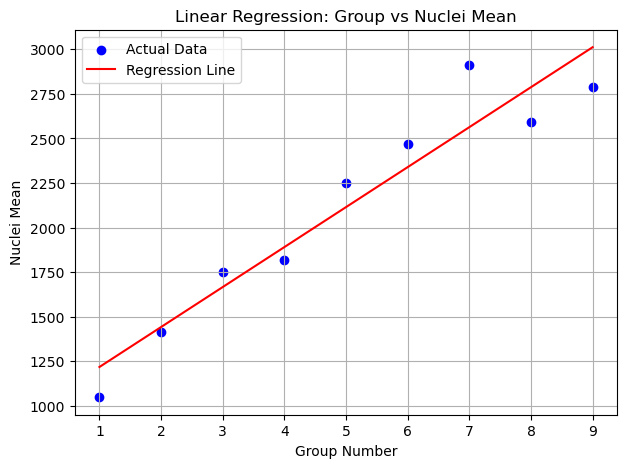

In [79]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

# Suppose 'df' is your DataFrame with the following columns:
# 'Group' (categorical or numerical), 'Nuclei_mean', 'Membranes_mean'
# Let's assume 'Group' is numerical or can be treated as a numeric time proxy.
# If 'Group' is not numeric, assign numeric indices or convert it appropriately.

# create a numeric index for regression:
df_summary['Group_num'] = df_summary['Group'].str.extract('(\d+)').astype(int)

# X is the independent variable (e.g., Group number as a proxy for time/stage)
X = df_summary['Group_num'].values

# y is the dependent variable (e.g., Nuclei_mean)
y = df_summary['Nuclei_mean'].values

# Add a constant (intercept) to the model
X = sm.add_constant(X)

# Fit an Ordinary Least Squares (OLS) regression
model = sm.OLS(y, X).fit()

# Print out the full statistical summary
print(model.summary())

X_groups = df_summary['Group_num']
y_actual = df_summary['Nuclei_mean']

# Generate a range of values for X to plot a smooth regression line
X_plot = np.linspace(X_groups.min(), X_groups.max(), 100)
X_plot_const = sm.add_constant(X_plot)
y_pred = model.predict(X_plot_const)

plt.figure(figsize=(7, 5))
plt.scatter(X_groups, y_actual, label='Actual Data', color='blue')
plt.plot(X_plot, y_pred, 'r-', label='Regression Line')

plt.xlabel('Group Number')
plt.ylabel('Nuclei Mean')
plt.title('Linear Regression: Group vs Nuclei Mean')
plt.grid(True)
plt.legend()
plt.show()

- R-squared: 0.982 suggests that about 98.2% of the variance in the dependent variable (y) is explained by the independent variable (Group). This is a very high value, indicating a strong linear relationship.

- Adj. R-squared: 0.979 is also very high, confirming the model is quite strong even after adjusting for the number of predictors.

- F-statistic: 373.2, p-value: 2.48e-07: The very low p-value means that the model is statistically significant; Group is a highly significant predictor of Nuclei_mean.

- Intercept (const) ~ 1011.7: When Group=0 (not a real scenario since your groups start at 1), predicted Nuclei_mean would be about 1011.7. This is just a baseline.

- Slope (x1) ~ 239.15: For each increment in Group number, the Nuclei_mean increases by about 239 cells on average.

- The confidence intervals [209.880, 268.429] for the slope do not include zero, reinforcing that the slope is significantly different from zero.

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.764
Model:                            OLS   Adj. R-squared:                  0.754
Method:                 Least Squares   F-statistic:                     77.77
Date:                Mon, 06 Jan 2025   Prob (F-statistic):           5.39e-09
Time:                        19:34:23   Log-Likelihood:                -185.18
No. Observations:                  26   AIC:                             374.4
Df Residuals:                      24   BIC:                             376.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        907.9122    134.063      6.772      0.0

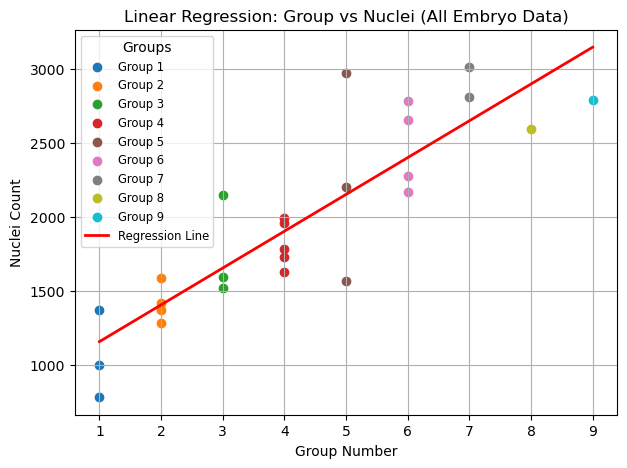

In [81]:
df_embryos['Group_num'] = df_embryos['Group'].str.extract('(\d+)').astype(int)

X = df_embryos['Group_num'].values
y = df_embryos['Nuclei'].values

X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
print(model.summary())

groups = sorted(df_embryos['Group_num'].unique())
colors = plt.cm.tab10(np.linspace(0,1,len(groups)))
group_colors = dict(zip(groups, colors))

plt.figure(figsize=(7,5))
for g in groups:
    g_data = df_embryos[df_embryos['Group_num'] == g]
    plt.scatter(g_data['Group_num'], g_data['Nuclei'], color=group_colors[g], label=f'Group {g}')

# Regression line
X_plot = np.linspace(df_embryos['Group_num'].min(), df_embryos['Group_num'].max(), 100)
X_plot_const = sm.add_constant(X_plot)
y_pred = model.predict(X_plot_const)
plt.plot(X_plot, y_pred, 'r-', label='Regression Line', linewidth=2)

plt.xlabel('Group Number')
plt.ylabel('Nuclei Count')
plt.title('Linear Regression: Group vs Nuclei (All Embryo Data)')
plt.grid(True)
handles, labels = plt.gca().get_legend_handles_labels()
unique = dict(zip(labels, handles))
plt.legend(unique.values(), unique.keys(), title='Groups', loc='best', fontsize='small')
plt.show()


- Model: Membranes = a*Group + b

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.925
Model:                            OLS   Adj. R-squared:                  0.914
Method:                 Least Squares   F-statistic:                     86.31
Date:                Mon, 06 Jan 2025   Prob (F-statistic):           3.47e-05
Time:                        19:34:15   Log-Likelihood:                -59.681
No. Observations:                   9   AIC:                             123.4
Df Residuals:                       7   BIC:                             123.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        809.5801    151.163      5.356      0.0

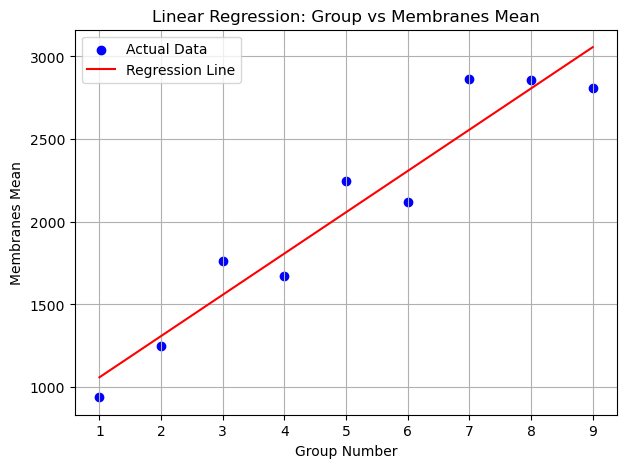

In [80]:
df_summary['Group_num'] = df_summary['Group'].str.extract('(\d+)').astype(int)

# X is the independent variable (e.g., Group number as a proxy for time/stage)
X = df_summary['Group_num'].values

# y is the dependent variable (e.g., Nuclei_mean)
y = df_summary['Membranes_mean'].values

# Add a constant (intercept) to the model
X = sm.add_constant(X)

# Fit an Ordinary Least Squares (OLS) regression
model = sm.OLS(y, X).fit()

# Print out the full statistical summary
print(model.summary())

X_groups = df_summary['Group_num']
y_actual = df_summary['Membranes_mean']

# Generate a range of values for X to plot a smooth regression line
X_plot = np.linspace(X_groups.min(), X_groups.max(), 100)
X_plot_const = sm.add_constant(X_plot)
y_pred = model.predict(X_plot_const)

plt.figure(figsize=(7, 5))
plt.scatter(X_groups, y_actual, label='Actual Data', color='blue')
plt.plot(X_plot, y_pred, 'r-', label='Regression Line')

plt.xlabel('Group Number')
plt.ylabel('Membranes Mean')
plt.title('Linear Regression: Group vs Membranes Mean')
plt.grid(True)
plt.legend()
plt.show()

- Model Fit Quality:
    R-squared (0.913): About 91.3% of the variance in the membranes count is explained by the group number. This is a high value, suggesting a strong linear relationship between the developmental group (as a proxy for time) and the membranes count.
    Adjusted R-squared (0.901): After adjusting for the number of predictors, the model still explains about 90.1% of the variance, indicating a robust fit.

- Statistical Significance:
    F-statistic (73.74) and p-value (5.78e-05): The very small p-value suggests that the overall linear model is statistically significant. It’s highly unlikely that this strong relationship is due to chance.

- Coefficients:
    Intercept (const = 875.8794): When the group index is zero (a hypothetical point before the earliest defined group), the model predicts approximately 876 membranes. While Group 0 does not exist in your actual experiment, this provides a baseline reference point.
    Slope (x1 = 224.7826): For each increment in the group number, the model predicts an increase of about 225 membranes on average. This is a substantial and highly significant effect, indicating that as you move through developmental time points (groups), the number of membranes consistently increases.

- Confidence Intervals and p-values:
    The 95% confidence interval for the slope is approximately [162.886, 286.679], which does not include zero. This reinforces that the slope is significantly different from zero.
    The low p-values for both the intercept and slope confirm that these estimates are statistically meaningful.

- Residual Diagnostics:
    Omnibus and Jarque-Bera tests: Both suggest no significant deviation from normality in the residuals, implying that the model’s assumptions about error distribution are not grossly violated.
    Durbin-Watson (2.901): This statistic is close to 3, which might indicate a slight negative autocorrelation in residuals, but given the small sample size (N=9), it is not too concerning. Still, it’s generally safer when DW is near 2 (no autocorrelation).

- Comparison to Nuclei Fit:
    While the fit for membranes is excellent (R²=0.913), the nuclei model had an even higher R² (0.982). This might reflect that nuclei counts are even more strongly or more consistently related to the developmental progression. The slightly lower R² for membranes could be due to segmentation underestimation or greater variability in identifying cell membranes.

Conclusion:
The linear regression model for membranes shows that the membranes count increases significantly as the groups progress. The relationship is strong, highly significant, and the model’s assumptions appear reasonable. Although slightly less perfect than the nuclei model’s fit, it still provides robust evidence that membranes also follow a roughly linear increase with developmental progression.

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.441
Model:                            OLS   Adj. R-squared:                  0.424
Method:                 Least Squares   F-statistic:                     26.81
Date:                Tue, 31 Dec 2024   Prob (F-statistic):           1.01e-05
Time:                        10:49:29   Log-Likelihood:                -278.40
No. Observations:                  36   AIC:                             560.8
Df Residuals:                      34   BIC:                             564.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        600.3536    213.120      2.817      0.0

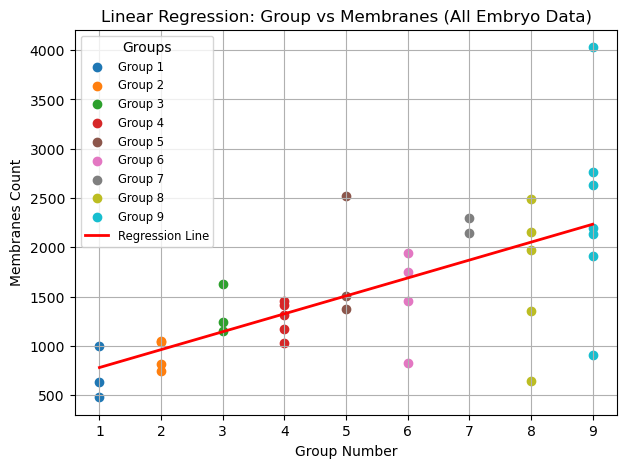

In [38]:
df_embryos['Group_num'] = df_embryos['Group'].str.extract('(\d+)').astype(int)

X = df_embryos['Group_num'].values
y = df_embryos['Membranes'].values

X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
print(model.summary())

groups = sorted(df_embryos['Group_num'].unique())
colors = plt.cm.tab10(np.linspace(0,1,len(groups)))
group_colors = dict(zip(groups, colors))

plt.figure(figsize=(7,5))
for g in groups:
    g_data = df_embryos[df_embryos['Group_num'] == g]
    plt.scatter(g_data['Group_num'], g_data['Membranes'], color=group_colors[g], label=f'Group {g}')
    
# Regression line
X_plot = np.linspace(df_embryos['Group_num'].min(), df_embryos['Group_num'].max(), 100)
X_plot_const = sm.add_constant(X_plot)

y_pred = model.predict(X_plot_const)
plt.plot(X_plot, y_pred, 'r-', label='Regression Line', linewidth=2)

plt.xlabel('Group Number')
plt.ylabel('Membranes Count')
plt.title('Linear Regression: Group vs Membranes (All Embryo Data)')
plt.grid(True)
handles, labels = plt.gca().get_legend_handles_labels()
unique = dict(zip(labels, handles))
plt.legend(unique.values(), unique.keys(), title='Groups', loc='best', fontsize='small')
plt.show()